In [ ]:
# Import necessary libraries
!pip install yfinance matplotlib pandas numpy tensorflow

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def get_financial_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="10y")
    financials = stock.financials.T
    balance_sheet = stock.balance_sheet.T
    cashflow = stock.cashflow.T
    return hist, financials, balance_sheet, cashflow

In [ ]:
df.head()

,Date,CreditScore,Rating,NormalizedCreditScore,PredictedRating
0,2021-01-31,442.711122,4,0.257126,BBB
1,2021-02-28,437.538248,1,0.247318,AAA
2,2021-03-31,486.118562,5,0.339429,BB
3,2021-04-30,733.846376,1,0.809133,AAA
4,2021-05-31,446.969147,1,0.265199,AA


In [ ]:
df.tail()


,Date,CreditScore,Rating,NormalizedCreditScore,PredictedRating
95,2028-12-31,337.692152,4,0.058005,BBB
96,2029-01-31,383.622213,2,0.145090,AA
97,2029-02-28,437.401726,2,0.247059,AA
98,2029-03-31,476.396413,3,0.320995,A
99,2029-04-30,561.129445,5,0.481653,BB


In [ ]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

In [ ]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [ ]:
X.head()

,Date,CreditScore,Rating,NormalizedCreditScore,PredictedRating
0,2021-01-31,401.177254,NaN,0.184011,BBB
1,2021-02-28,361.646169,NaN,0.111678,BBB
2,2021-03-31,770.743733,NaN,0.860231,AAA
3,2021-04-30,405.324056,NaN,0.191598,BBB
4,2021-05-31,819.535865,NaN,0.949510,AAA


In [ ]:
# Fetch the historical data for a given ticker
ticker = 'AAPL'
hist = get_financial_data(ticker)

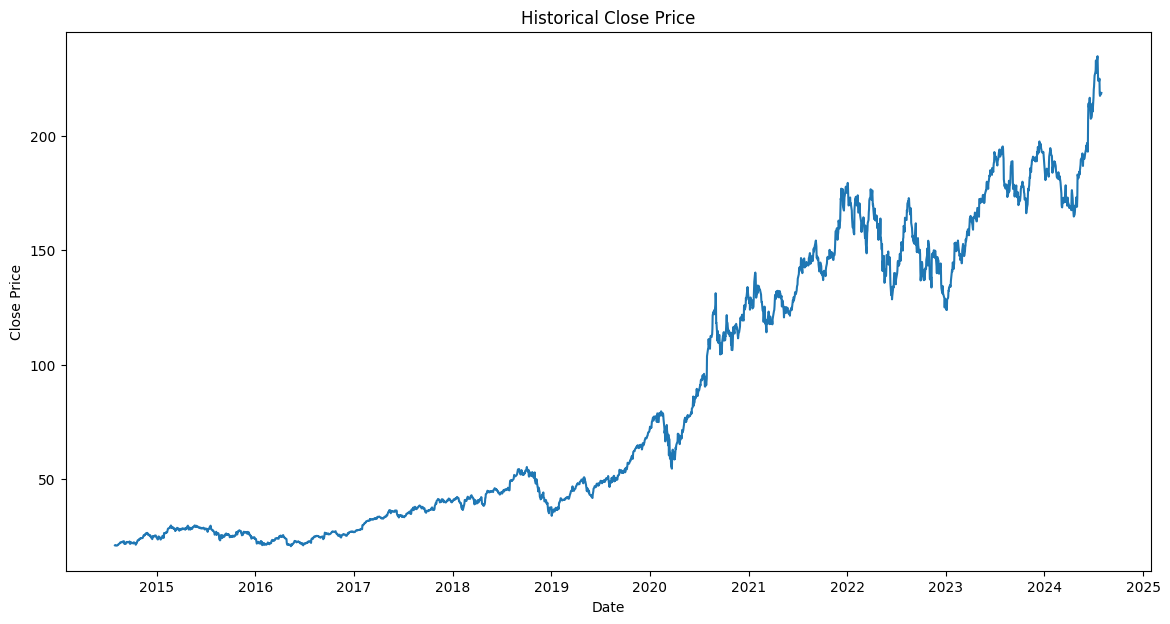

In [ ]:
# Fetch the historical data for a given ticker
ticker = 'AAPL'
hist, _, _, _ = get_financial_data(ticker) # Unpack the tuple

# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(hist['Close'])
plt.title('Historical Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Preprocess the data
def preprocess_data(df):
    # Use only the 'Close' price for simplicity
    data = df[['Close']].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Block 5: Define function to create the dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

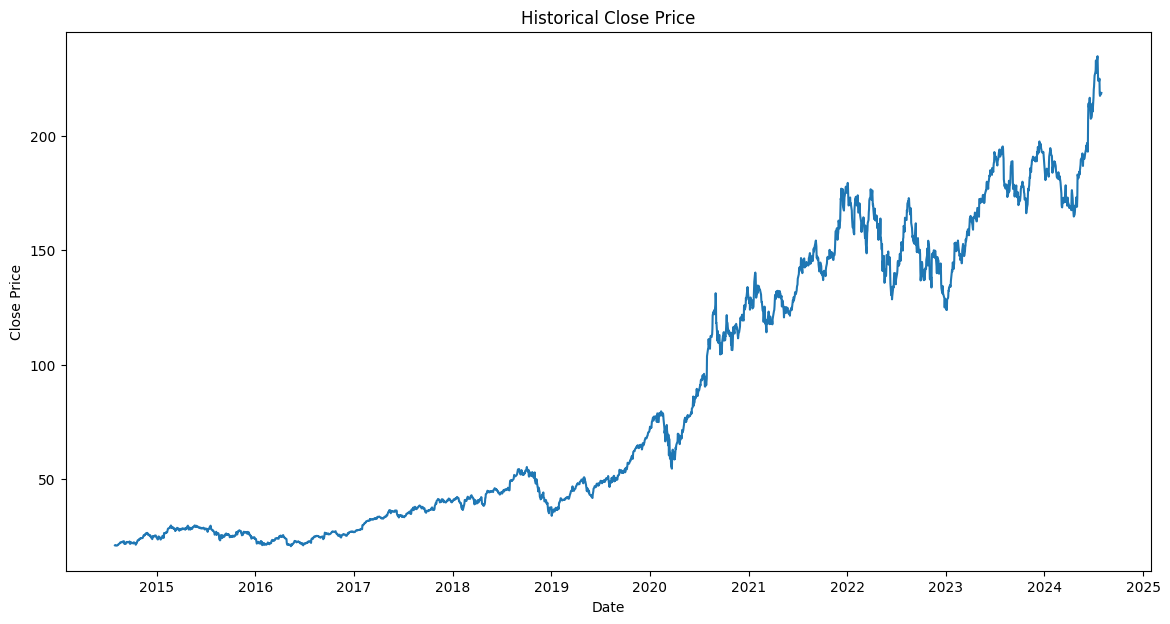

In [ ]:
# Block 6: Fetch and preprocess the historical data for a given ticker and plot it
ticker = 'AAPL'
hist, _, _, _ = get_financial_data(ticker) # Unpack the tuple to get the DataFrame

plt.figure(figsize=(14, 7))
plt.plot(hist['Close']) # Now hist should be a DataFrame
plt.title('Historical Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Normalize the data
scaled_data, scaler = normalize_data(hist[['Close']].values)

# Define the time step
time_step = 100

In [ ]:
# Create the dataset
X, Y = create_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)


In [ ]:
def credit_score_to_rating(credit_score):
    if credit_score >= 800:
        return "AAA"
    elif credit_score >= 740:
        return "AA"
    elif credit_score >= 670:
        return "A"
    elif credit_score >= 580:
        return "BBB"
    elif credit_score >= 500:
        return "BB"
    elif credit_score >= 400:
        return "B"
    elif credit_score >= 300:
        return "CCC"
    else: return "D"

In [ ]:
def calculate_credit_score(financials, balance_sheet, cashflow):
    # Calculate required metrics
    net_profit = financials['Net Income']
    revenue = financials['Total Revenue']
    operating_profit = financials['Operating Income']

    # Example calculation for growth rate
    net_profit_growth = net_profit.pct_change().mean() * 100
    revenue_growth = revenue.pct_change().mean() * 100
    operating_profit_growth = operating_profit.pct_change().mean() * 100

    # Calculate cashflow metrics
    cfo = cashflow.loc['Cash from Operations']
    cfi = cashflow.loc['Cash from Investing Activities']

    # Define conditions
    conditions_met = {
        'Net Profit Positive': net_profit.mean() > 0,
        'Debt Positive Equity': (balance_sheet.loc['Total Liabilities Net Minority Interest'] / balance_sheet.loc['Total Shareholder Equity']).mean() > 1,
        'Current Assets > 1': balance_sheet.loc['Total Current Assets'].mean() > 1,
        'CFO >= |CFI|': cfo.mean() >= abs(cfi.mean())
    }

    # Calculate Credit Score
    score = sum(conditions_met.values()) / len(conditions_met) * 100
    rating = credit_score_to_rating(score)

    return score, rating, conditions_met

In [ ]:
def calculate_credit_score(financials, balance_sheet, cashflow):
    # Calculate required metrics
    net_profit = financials.loc['Net Income']
    revenue = financials.loc['Total Revenue']
    operating_profit = financials.loc['Operating Income']

    # Example calculation for growth rate
    net_profit_growth = net_profit.pct_change().mean() * 100
    revenue_growth = revenue.pct_change().mean() * 100
    operating_profit_growth = operating_profit.pct_change().mean() * 100

    # Calculate cashflow metrics
    cfo = cashflow.loc['Cash from Operations']
    cfi = cashflow.loc['Cash from Investing Activities']

    # Define conditions
    conditions_met = {
        'Net Profit Positive': net_profit.mean() > 0,
        'Debt Positive Equity': (balance_sheet.loc['Total Liabilities Net Minority Interest'] / balance_sheet.loc['Total Shareholder Equity']).mean() > 1,
        'Current Assets > 1': balance_sheet.loc['Total Current Assets'].mean() > 1,
        'CFO >= |CFI|': cfo.mean() >= abs(cfi.mean())
    }

    # Calculate Credit Score
    score = sum(conditions_met.values()) / len(conditions_met) * 100

    return score, conditions_met

In [ ]:
# Block 7: Define function to preprocess and visualize data
def preprocess_and_plot_data(ticker):
    hist, financials, balance_sheet, cashflow = get_financial_data(ticker)

    # Plot historical data
    plt.figure(figsize=(14, 7))
    plt.plot(hist['Close'])
    plt.title('Historical Close Price')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

    # Normalize and create dataset
    scaled_data, scaler = normalize_data(hist[['Close']].values)
    time_step = 100
    X, Y = create_dataset(scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.65)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

    # Define and train the model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=64, verbose=1)

    # Predict the stock prices
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Transform back to original scale
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Plot the predictions
    plt.figure(figsize=(14, 7))
    plt.plot(hist.index, scaler.inverse_transform(scaled_data), label='Original Data')

    # Calculate indices for predictions
    train_len = len(train_predict)
    test_len = len(test_predict)
    train_indices = hist.index[time_step:time_step + train_len]
    test_indices = hist.index[len(X_train) + time_step + 1: len(X_train) + time_step + 1 + test_len]

    plt.plot(train_indices, train_predict, label='Train Prediction')
    plt.plot(test_indices, test_predict, label='Test Prediction')
    plt.title('Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Calculate and display credit score
    credit_score, conditions_met = calculate_credit_score(financials, balance_sheet, cashflow)
    print(f"Credit Score: {credit_score:.2f}%")
    print("Conditions Met:")
    for condition, met in conditions_met.items():
        print(f"{condition}: {'Yes' if met else 'No'}")



In [ ]:
# Block 7: Define function to preprocess and visualize data
def preprocess_and_plot_data(ticker):
    hist, financials, balance_sheet, cashflow = get_financial_data(ticker)

    # Plot historical data
    plt.figure(figsize=(14, 7))
    plt.plot(hist['Close'])
    plt.title('Historical Close Price')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

    # Normalize and create dataset
    scaled_data, scaler = normalize_data(hist[['Close']].values)
    time_step = 100
    X, Y = create_dataset(scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.65)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

    # Define and train the model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=64, verbose=1)

    # Predict the stock prices
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Transform back to original scale
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Plot the predictions
    plt.figure(figsize=(14, 7))
    plt.plot(hist.index, scaler.inverse_transform(scaled_data), label='Original Data')

    # Calculate indices for predictions
    train_len = len(train_predict)
    test_len = len(test_predict)
    train_indices = hist.index[time_step:time_step + train_len]
    test_indices = hist.index[len(X_train) + time_step + 1: len(X_train) + time_step + 1 + test_len]

    plt.plot(train_indices, train_predict, label='Train Prediction')
    plt.plot(test_indices, test_predict, label='Test Prediction')
    plt.title('Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Calculate and display credit score
    credit_score, rating, conditions_met = calculate_credit_score(financials, balance_sheet, cashflow)
    print(f"Credit Score: {credit_score:.2f}%")
    print(f"Credit Rating: {rating}%")
    print("Conditions Met:")
    for condition, met in conditions_met.items():
        print(f"{condition}: {'Yes' if met else 'No'}")

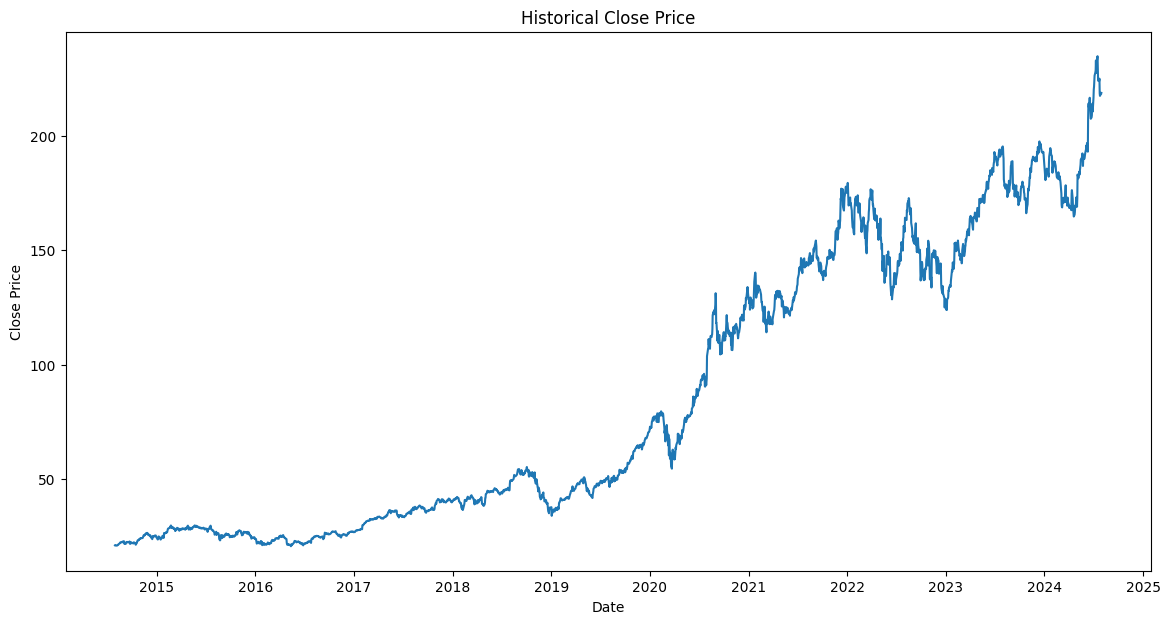

Epoch 1/10
25/25 [==============================] - 16s 302ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 2/10
25/25 [==============================] - 8s 320ms/step - loss: 4.9745e-04 - val_loss: 0.0017
Epoch 3/10
25/25 [==============================] - 6s 226ms/step - loss: 3.0141e-04 - val_loss: 0.0015
Epoch 4/10
25/25 [==============================] - 7s 302ms/step - loss: 2.4190e-04 - val_loss: 0.0015
Epoch 5/10
25/25 [==============================] - 5s 216ms/step - loss: 2.4267e-04 - val_loss: 0.0038
Epoch 6/10
25/25 [==============================] - 7s 284ms/step - loss: 2.2709e-04 - val_loss: 0.0017
Epoch 7/10
25/25 [==============================] - 10s 422ms/step - loss: 2.2672e-04 - val_loss: 0.0014
Epoch 8/10
25/25 [==============================] - 9s 356ms/step - loss: 2.0755e-04 - val_loss: 0.0013
Epoch 9/10
25/25 [==============================] - 6s 245ms/step - loss: 2.6595e-04 - val_loss: 0.0013
Epoch 10/10
27/27 [==============================] - 1s 44ms/step


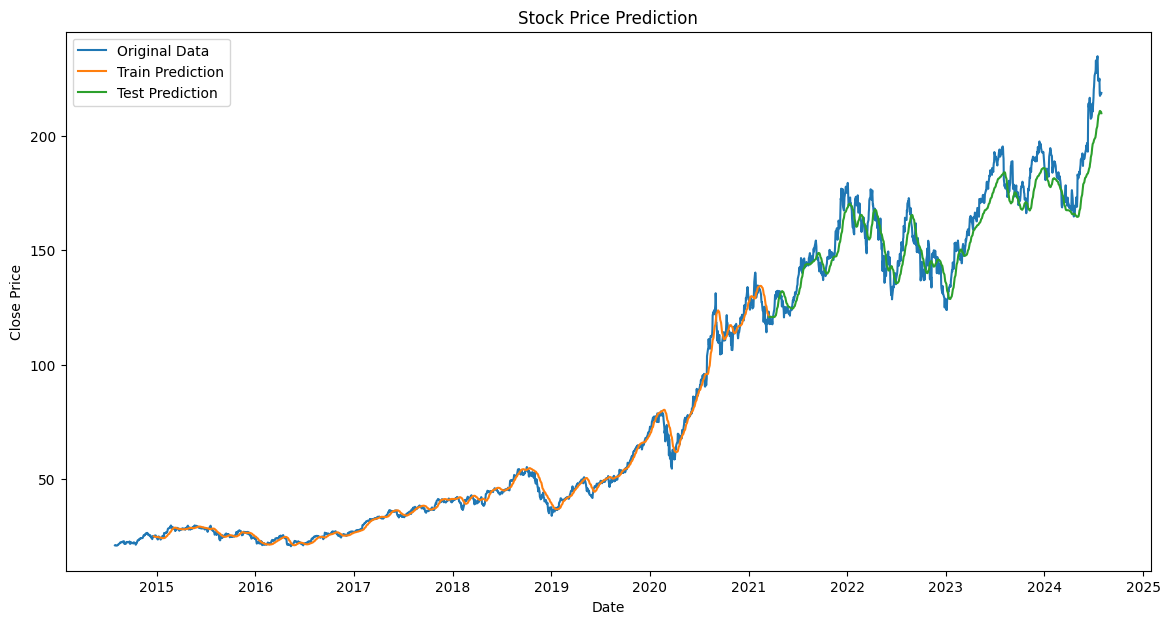

Financials Columns:
DatetimeIndex(['2023-09-30', '2022-09-30', '2021-09-30', '2020-09-30'], dtype='datetime64[ns]', freq=None)

Balance Sheet Columns:
DatetimeIndex(['2023-09-30', '2022-09-30', '2021-09-30', '2020-09-30',
               '2019-09-30'],
              dtype='datetime64[ns]', freq=None)

Cashflow Columns:
DatetimeIndex(['2023-09-30', '2022-09-30', '2021-09-30', '2020-09-30',
               '2019-09-30'],
              dtype='datetime64[ns]', freq=None)


KeyError: 'Total Cash From Operating Activities'

In [ ]:
# Block 8: Execute the function for a specific ticker
ticker = 'AAPL'
preprocess_and_plot_data(ticker)

In [ ]:
def display(ticker):
  hist, financials, balance_sheet, cashflow = get_financial_data(ticker)
  # Calculate and display credit score
  credit_score, rating, conditions_met = calculate_credit_score(financials, balance_sheet, cashflow)
  print(f"Credit Score: {credit_score:.2f}%")
  print(f"Credit Rating: {rating}%")
  print("Conditions Met:")
  ticker = 'AAPL'
  display(ticker)



In [ ]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.65)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Train the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=15, batch_size=64, verbose=1)


In [ ]:
# Predict the stock prices
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
# Transform back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# Calculate the indices for train and test predictions
train_len = len(train_predict)
test_len = len(test_predict)

# Create arrays of the same length for plotting
train_indices = hist.index[time_step:time_step + train_len]
test_indices = hist.index[len(X_train) + time_step + 1: len(X_train) + time_step + 1 + test_len]

# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(hist.index, scaler.inverse_transform(scaled_data), label='Original Data')

# Ensure train_indices and train_predict are the same length
plt.plot(train_indices, scaler.inverse_transform(train_predict), label='Train Prediction')

# Ensure test_indices and test_predict are the same length
plt.plot(test_indices, scaler.inverse_transform(test_predict), label='Test Prediction')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Dummy data for demonstration (replace with actual data)
def get_credit_data():
    # Generating synthetic data for demonstration
    dates = pd.date_range(start='2021-01-01', periods=100, freq='M')
    credit_scores = np.random.uniform(300, 850, size=len(dates))
    ratings = np.random.choice(['AAA', 'AA', 'A', 'BBB', 'BB'], size=len(dates))
    return pd.DataFrame({'Date': dates, 'CreditScore': credit_scores, 'Rating': ratings})

def preprocess_credit_data(df):
    # Encode the ratings into numerical values
    rating_mapping = {'AAA': 1, 'AA': 2, 'A': 3, 'BBB': 4, 'BB': 5}
    df['Rating'] = df['Rating'].map(rating_mapping)

    # Normalize credit scores
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['NormalizedCreditScore'] = scaler.fit_transform(df[['CreditScore']])

    return df, scaler




In [ ]:
def train_credit_rating_model(df):
    # Prepare features and labels
    X = df[['NormalizedCreditScore']]
    y = df['Rating']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return model


Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.33      0.40         3
           2       0.50      0.25      0.33         4
           3       0.25      0.29      0.27         7
           4       0.29      0.50      0.36         4
           5       0.00      0.00      0.00         2

    accuracy                           0.30        20
   macro avg       0.31      0.27      0.27        20
weighted avg       0.32      0.30      0.29        20

Confusion Matrix:
[[1 1 1 0 0]
 [0 1 2 0 1]
 [1 0 2 4 0]
 [0 0 2 2 0]
 [0 0 1 1 0]]


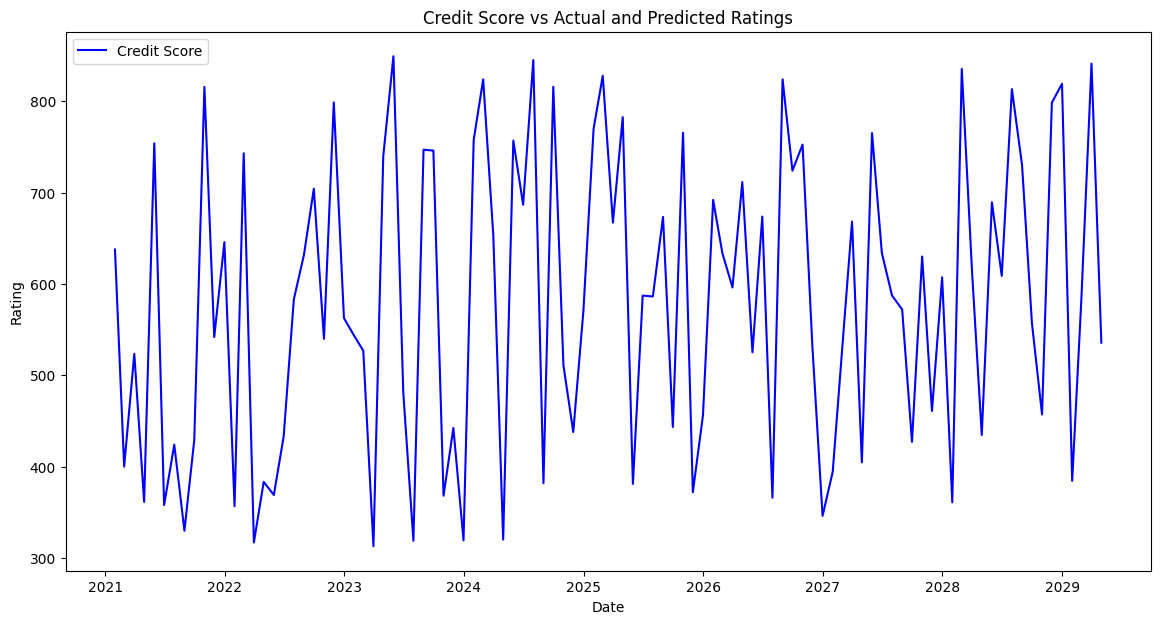

In [ ]:
def plot_credit_score_predictions(df, model, scaler):
    # Predict ratings for the entire dataset
    df['PredictedRating'] = model.predict(df[['NormalizedCreditScore']])

    # Reverse map ratings to original labels
    reverse_mapping = {1: 'AAA', 2: 'AA', 3: 'A', 4: 'BBB', 5: 'BB'}
    df['PredictedRating'] = df['PredictedRating'].map(reverse_mapping)

    # Plot actual vs predicted ratings
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['CreditScore'], label='Credit Score', color='blue')


    plt.title('Credit Score vs Actual and Predicted Ratings')
    plt.xlabel('Date')
    plt.ylabel('Rating')
    plt.legend()
    plt.show()

# Example usage
df = get_credit_data()
df, scaler = preprocess_credit_data(df)
model = train_credit_rating_model(df)
plot_credit_score_predictions(df, model, scaler)
